# Eksperimenter med andre typer fits

In [147]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [148]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

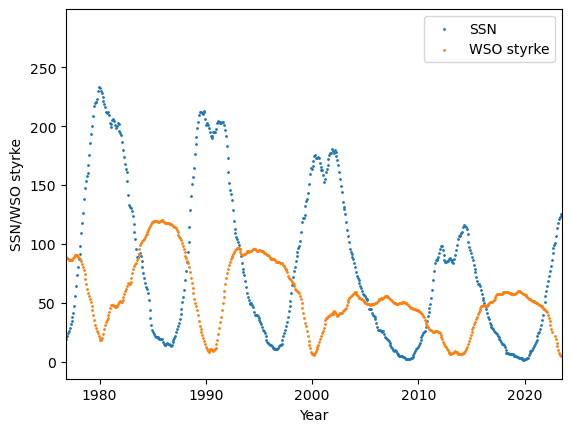

In [149]:
# Indlæs data

loc1 = r"C:\Users\marcu\OneDrive\Documents\GitHub\Solpletter_projekt\Magnus carlsen\data\13-month smoothed monthly total sunspot number 1-1749 to now.csv"
loc2 = r"C:\Users\marcu\OneDrive\Documents\GitHub\Solpletter_projekt\Magnus carlsen\data\WSO_smoothed.csv"

column_names = ['Year', 'Year_fraction', 'Monthly_smoothed_sunspot_number', 'U1', 'U2', 'U3']
sunspot_raw_data = pd.read_csv(loc1, names=column_names, delimiter=';')
sunspot_raw_data = sunspot_raw_data.iloc[6:-6]

# Sunspot data
sunspot_date_fraction_arr = sunspot_raw_data['Year_fraction'].values.astype(float)
sunspot_number_arr = sunspot_raw_data['Monthly_smoothed_sunspot_number'].values.astype(float)

# WSO data
wso_raw_data = np.genfromtxt(loc2, delimiter=',', skip_header=1)

wso_date_fraction_arr = wso_raw_data[:, 0]
wso_number_arr = wso_raw_data[:, 1]

# Størrelse på punkterne i scatterplottet
ScatterSize = 1

# Plot data
plt.scatter(sunspot_date_fraction_arr, sunspot_number_arr, label='SSN', s=ScatterSize)
plt.scatter(wso_date_fraction_arr, wso_number_arr, label='WSO styrke', s=ScatterSize)
plt.xlabel('Year')
plt.ylabel('SSN/WSO styrke')
plt.xlim(wso_date_fraction_arr[0], wso_date_fraction_arr[-1])
plt.legend()
plt.show()

## Decision tree

In [150]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from joblib import parallel_backend

with parallel_backend('threading', n_jobs=-1):

    X = sunspot_date_fraction_arr[:, np.newaxis]
    Y = sunspot_number_arr

    regr_1 = DecisionTreeRegressor(max_depth=None)
    regr_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=None), n_estimators=300)

    regr_1.fit(X, Y)
    regr_2.fit(X, Y)




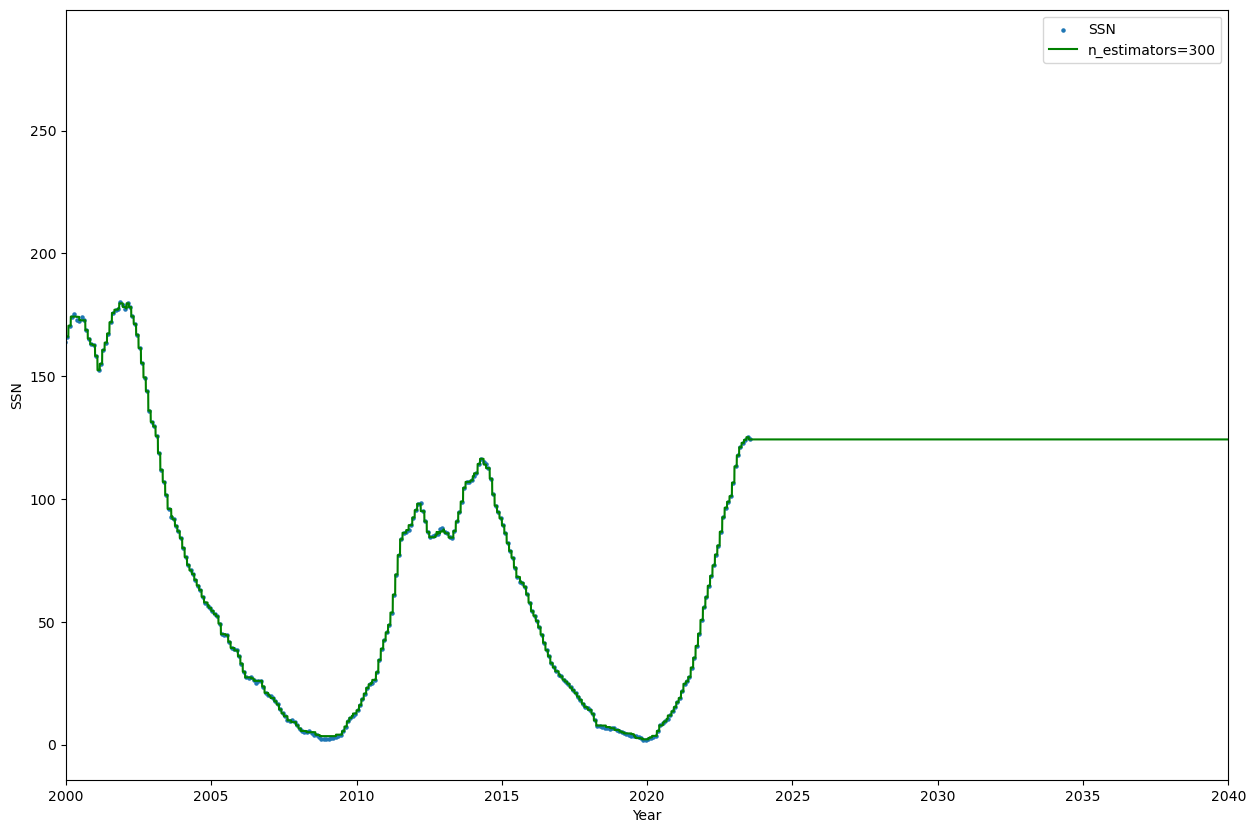

In [151]:
# Predict
X_test = np.linspace(2000, 2040, len(sunspot_date_fraction_arr)*10)[:, np.newaxis]

y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)


ScatterSize = 5
# Plot og sammenlign fits
plt.figure(figsize=(15, 10))
plt.scatter(X, Y, label='SSN', s=ScatterSize)
plt.plot(X_test, y_2, label="n_estimators=300", color='g')
#plt.plot(X_test, y_1, label="n_estimators=1", color='r')
plt.xlabel('Year')
plt.ylabel('SSN')
plt.xlim(2000, 2040)
plt.legend()
plt.show()



In [152]:
# Skær arrays til så de har samme længde
min_length = min(len(sunspot_number_arr), len(wso_number_arr))
X = wso_number_arr[-min_length:]
Y = sunspot_number_arr[-min_length:]

In [153]:
# Split cykler op i 5 arrays
division_proxy = [wso_date_fraction_arr[0], 1986.5, 1996.5, 2009, 2020, wso_date_fraction_arr[-1]]

wso_cycles = []
SSN_cycles = []
# Loop igennem opdelingsdatoerne
for i in range(1, len(division_proxy)):
    current_division_date = division_proxy[i]
    previous_division_date = division_proxy[i-1]
    
    current_wso_cycle = []
    current_SSN_cycle = []

    # Loop igennem alle datoer og tilføj data til den nuværende cyklus hvis de er indenfor intervallet
    for date in wso_date_fraction_arr:
        if date >= previous_division_date and date < current_division_date:
            current_wso_cycle.append([date, wso_number_arr[-min_length:][np.where(wso_date_fraction_arr == date)[0][0]]])
            current_SSN_cycle.append([date, sunspot_number_arr[-min_length:][np.where(wso_date_fraction_arr == date)[0][0]]])

    wso_cycles.append(np.array(current_wso_cycle))
    SSN_cycles.append(np.array(current_SSN_cycle))



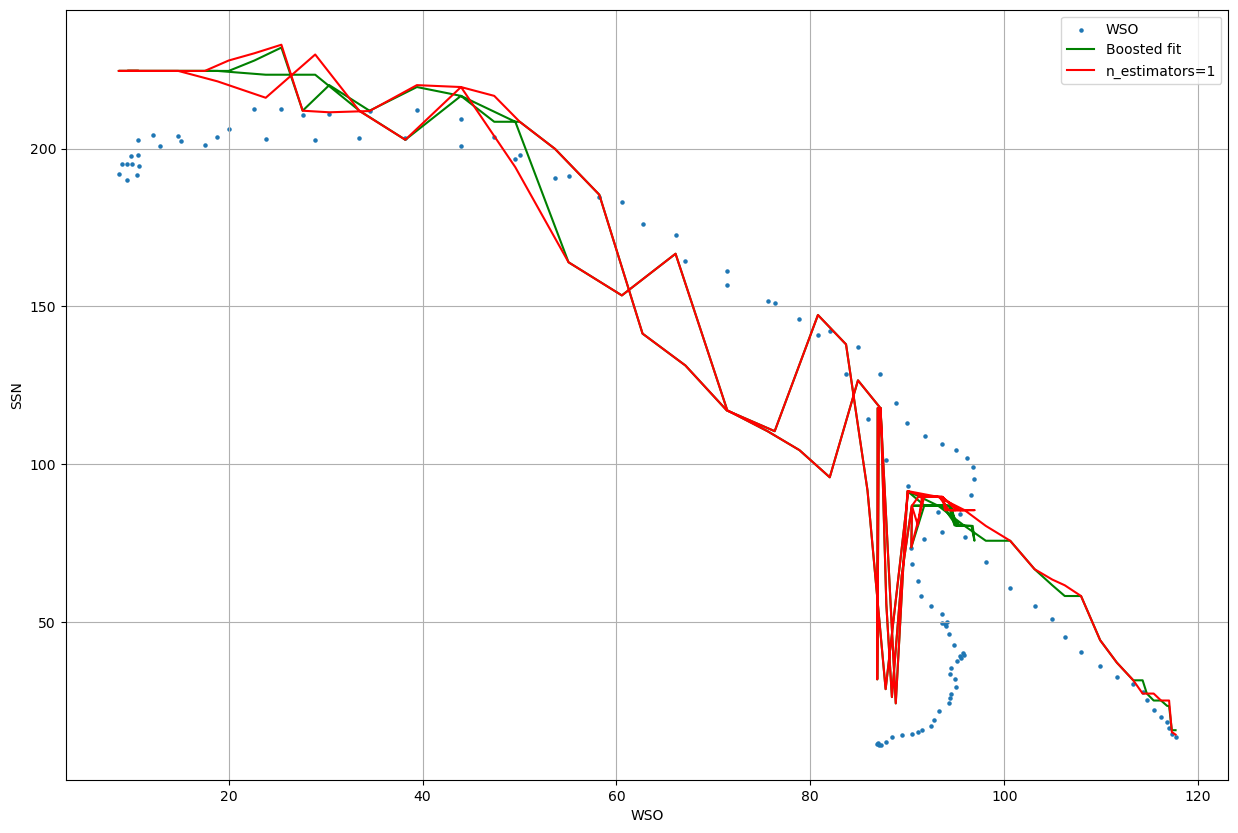

In [191]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from joblib import parallel_backend

WSO = wso_cycles[0][:, 1]
SSN = SSN_cycles[0][:, 1]
TIME = wso_cycles[0][:, 0]

WSOf = WSO

with parallel_backend('threading', n_jobs=1):
    WSOf = WSOf[:, np.newaxis]

    regr_1 = DecisionTreeRegressor(max_depth=None)
    regr_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=None), n_estimators=300)

    regr_1.fit(WSOf, SSN)
    regr_2.fit(WSOf, SSN)

# Predict
X_test = wso_cycles[1][:, 1]
X_test = X_test[:, np.newaxis]

Y_test = SSN_cycles[1][:, 1]

y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)

# Plot og sammenlign fits
plt.figure(figsize=(15, 10))
plt.scatter(X_test[:, 0], Y_test, label='WSO', s=ScatterSize)
plt.plot(X_test, y_2, label="Boosted fit", color='g')
plt.plot(X_test, y_1, label="n_estimators=1", color='r')
plt.xlabel('WSO')
plt.ylabel('SSN')

plt.grid(True)
plt.legend()
plt.show()

